In [1]:
import networkx as nx
from ipysigma import Sigma
from utils import load_graph_v3, load_graph_v3_rustworkx
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import nx_parallel as nxp
import rustworkx as rx
import powerlaw
import igraph as ig

In [2]:
PATH_TO_GRAPH = "spotify_graph_l0renzz_5.jsonl"

In [3]:
R, id_map = load_graph_v3_rustworkx(PATH_TO_GRAPH)

In [4]:

G = load_graph_v3(PATH_TO_GRAPH)
G_undirected = G.to_undirected()


In [6]:
#count lines aka number of users originally scraped
with open("checkpoint_l0renzz.json", "r") as f:
    num_lines = sum(1 for _ in f)
print(num_lines)

1383956


In [7]:

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
print(f"Rustworkx Nodes: {len(R.nodes())}, Edges: {len(R.edges())}")

Nodes: 1077947, Edges: 4730419
Rustworkx Nodes: 1077947, Edges: 5609673


nNumber of Users with 0 followers: 36355


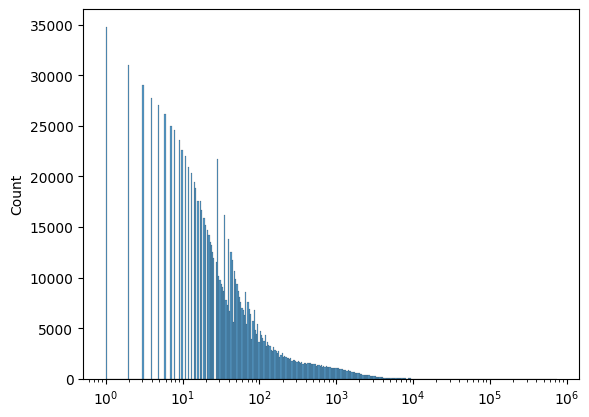

In [ ]:
# data_dict = {}
# for node in G.nodes():
#     followers_count = G.nodes[node].get('followers_count')
#     if followers_count is not None:
#         data_dict[node] = followers_count
#     else:
#         data_dict[node] = G.in_degree(node)

# user_indegree_series = pd.Series(data_dict)
user_indegree_series = pd.Series({node: G.nodes[node].get('followers_count', G.in_degree(node)) for node in G.nodes()})
sns.histplot(user_indegree_series, log_scale=True)
print("nNumber of Users with 0 followers:", (user_indegree_series == 0).sum())

## Power Law Test

In [ ]:
followers_data = user_indegree_series[user_indegree_series > 0].values

# Fit power law
fit = powerlaw.Fit(followers_data, discrete=True)

print("Power Law Analysis Results:")
print(f"Alpha (power law exponent): {fit.power_law.alpha:.3f}")
print(f"xmin: {fit.power_law.xmin:.2f}")
print(f"Data points used: {len(followers_data[followers_data >= fit.power_law.xmin])}/{len(followers_data)}")

Calculating best minimal value for power law fit


Fitting xmin: 100%|██████████| 4919/4919 [00:42<00:00, 115.83it/s]


Power Law Analysis Results:
Alpha (power law exponent): 1.843
xmin: 30.00
Data points used: 422036/991429



=== Distribution Comparison (Likelihood Ratio Tests) ===

Power Law vs Lognormal:
  Loglikelihood ratio R: -38.415
  p-value: 0.000000000000
  → Lognormal is a better fit

Power Law vs Exponential:
  Loglikelihood ratio R: 93.408
  p-value: 0.000000000000
  → Power law is a better fit

Power Law vs Truncated Power Law:
  Loglikelihood ratio R: -3089.775
  p-value: 0.000000000000
  → Truncated power law is a better fit

Power Law vs Stretched Exponential:
  Loglikelihood ratio R: 24.818
  p-value: 0.000000000000
  → Power law is a better fit

Lognormal vs Exponential:
  Loglikelihood ratio R: 94.703
  p-value: 0.000000000000
  → Lognormal is a better fit

Lognormal vs Truncated Power Law:
  Loglikelihood ratio R: -9.652
  p-value: 0.000000000000
  → Truncated power law is a better fit

Lognormal vs Stretched Exponential:
  Loglikelihood ratio R: 50.817
  p-value: 0.000000000000
  → Lognormal is a better fit


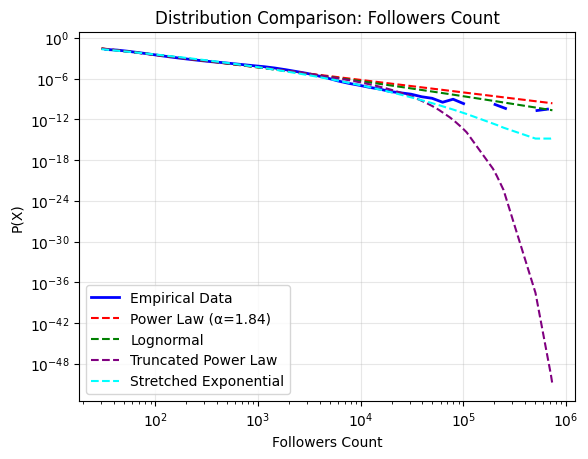

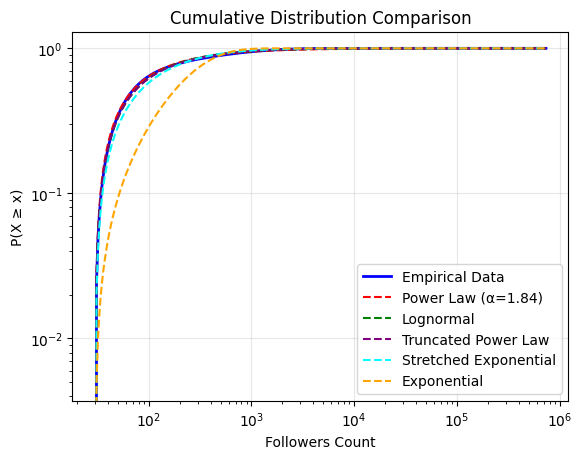

In [ ]:
# Compare power law to lognormal and exponential using likelihood ratio tests
print("\n=== Distribution Comparison (Likelihood Ratio Tests) ===\n")

# Power Law vs Lognormal
R_pl_ln, p_pl_ln = fit.distribution_compare('power_law', 'lognormal', normalized_ratio=True)
print(f"Power Law vs Lognormal:")
print(f"  Loglikelihood ratio R: {R_pl_ln:.3f}")
print(f"  p-value: {p_pl_ln:.12f}")
if R_pl_ln > 0:
    print(f"  → Power law is a better fit" if p_pl_ln < 0.05 else f"  → No significant difference (p >= 0.05)")
else:
    print(f"  → Lognormal is a better fit" if p_pl_ln < 0.05 else f"  → No significant difference (p >= 0.05)")

# Power Law vs Exponential
R_pl_exp, p_pl_exp = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print(f"\nPower Law vs Exponential:")
print(f"  Loglikelihood ratio R: {R_pl_exp:.3f}")
print(f"  p-value: {p_pl_exp:.12f}")
if R_pl_exp > 0:
    print(f"  → Power law is a better fit" if p_pl_exp < 0.05 else f"  → No significant difference (p >= 0.05)")
else:
    print(f"  → Exponential is a better fit" if p_pl_exp < 0.05 else f"  → No significant difference (p >= 0.05)")

# Power Law vs Truncated Power Law
R_pl_tpl, p_pl_tpl = fit.distribution_compare('power_law', 'truncated_power_law', nested=True)
print(f"\nPower Law vs Truncated Power Law:")
print(f"  Loglikelihood ratio R: {R_pl_tpl:.3f}")
print(f"  p-value: {p_pl_tpl:.12f}")
if R_pl_tpl > 0:
    print(f"  → Power law is a better fit" if p_pl_tpl < 0.05 else f"  → No significant difference (p >= 0.05)")
else:
    print(f"  → Truncated power law is a better fit" if p_pl_tpl < 0.05 else f"  → No significant difference (p >= 0.05)")

# Power Law vs Stretched Exponential
R_pl_se, p_pl_se = fit.distribution_compare('power_law', 'stretched_exponential', normalized_ratio=True)
print(f"\nPower Law vs Stretched Exponential:")
print(f"  Loglikelihood ratio R: {R_pl_se:.3f}")
print(f"  p-value: {p_pl_se:.12f}")
if R_pl_se > 0:
    print(f"  → Power law is a better fit" if p_pl_se < 0.05 else f"  → No significant difference (p >= 0.05)")
else:
    print(f"  → Stretched exponential is a better fit" if p_pl_se < 0.05 else f"  → No significant difference (p >= 0.05)")

# Lognormal vs Exponential
R_ln_exp, p_ln_exp = fit.distribution_compare('lognormal', 'exponential', normalized_ratio=True)
print(f"\nLognormal vs Exponential:")
print(f"  Loglikelihood ratio R: {R_ln_exp:.3f}")
print(f"  p-value: {p_ln_exp:.12f}")
if R_ln_exp > 0:
    print(f"  → Lognormal is a better fit" if p_ln_exp < 0.05 else f"  → No significant difference (p >= 0.05)")
else:
    print(f"  → Exponential is a better fit" if p_ln_exp < 0.05 else f"  → No significant difference (p >= 0.05)")

# Lognormal vs Truncated Power Law
R_ln_tpl, p_ln_tpl = fit.distribution_compare('lognormal', 'truncated_power_law', normalized_ratio=True)
print(f"\nLognormal vs Truncated Power Law:")
print(f"  Loglikelihood ratio R: {R_ln_tpl:.3f}")
print(f"  p-value: {p_ln_tpl:.12f}")
if R_ln_tpl > 0:
    print(f"  → Lognormal is a better fit" if p_ln_tpl < 0.05 else f"  → No significant difference (p >= 0.05)")
else:
    print(f"  → Truncated power law is a better fit" if p_ln_tpl < 0.05 else f"  → No significant difference (p >= 0.05)")

# Lognormal vs Stretched Exponential
R_ln_se, p_ln_se = fit.distribution_compare('lognormal', 'stretched_exponential', normalized_ratio=True)
print(f"\nLognormal vs Stretched Exponential:")
print(f"  Loglikelihood ratio R: {R_ln_se:.3f}")
print(f"  p-value: {p_ln_se:.12f}")
if R_ln_se > 0:
    print(f"  → Lognormal is a better fit" if p_ln_se < 0.05 else f"  → No significant difference (p >= 0.05)")
else:
    print(f"  → Stretched exponential is a better fit" if p_ln_se < 0.05 else f"  → No significant difference (p >= 0.05)")

# Visualize the distribution with fitted curves
fig = fit.plot_pdf(color='b', linewidth=2, label='Empirical Data')
fit.power_law.plot_pdf(color='r', linestyle='--', label=f'Power Law (α={fit.power_law.alpha:.2f})')
fit.lognormal.plot_pdf(color='g', linestyle='--', label='Lognormal')
fit.truncated_power_law.plot_pdf(color='purple', linestyle='--', label='Truncated Power Law')
fit.stretched_exponential.plot_pdf(color='cyan', linestyle='--', label='Stretched Exponential')
#fit.exponential.plot_pdf(color='orange', linestyle='--', label='Exponential')

plt.xlabel('Followers Count')
plt.ylabel('P(X)')
plt.title('Distribution Comparison: Followers Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#visualize cdf comparison
fig = fit.plot_cdf(color='b', linewidth=2, label='Empirical Data')
fit.power_law.plot_cdf(color='r', linestyle='--', label=f'Power Law (α={fit.power_law.alpha:.2f})')
fit.lognormal.plot_cdf(color='g', linestyle='--', label='Lognormal')
fit.truncated_power_law.plot_cdf(color='purple', linestyle='--', label='Truncated Power Law')
fit.stretched_exponential.plot_cdf(color='cyan', linestyle='--', label='Stretched Exponential')
fit.exponential.plot_cdf(color='orange', linestyle='--', label='Exponential')

plt.xlabel('Followers Count')
plt.ylabel('P(X ≥ x)')
plt.title('Cumulative Distribution Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
#print example users with highest indegree
top_users = user_indegree_series.sort_values(ascending=False).head(10)
top_users_out_vs_indegree = {}
for user_id in top_users.index:
    out_degree = G.out_degree(user_id)
    in_degree = G.in_degree(user_id)
    top_users_out_vs_indegree[user_id] = (out_degree, in_degree)
print("Top 10 users by followers count:")
for user_id, followers_count in top_users.items():
    print(f"User ID: {user_id}, Followers Count: {followers_count}")
    print(f"    Out-degree (following): {top_users_out_vs_indegree[user_id][0]}, In-degree (followers): {top_users_out_vs_indegree[user_id][1]}")

Top 10 users by followers count:
User ID: myplay.com, Followers Count: 736428
    Out-degree (following): 1, In-degree (followers): 0
User ID: coca-cola, Followers Count: 712690
    Out-degree (following): 1, In-degree (followers): 0
User ID: napstersean, Followers Count: 504002
    Out-degree (following): 1, In-degree (followers): 0
User ID: mejoreslistasspotify, Followers Count: 246284
    Out-degree (following): 1, In-degree (followers): 0
User ID: cl4pu66mupttwuzei265gpsjf, Followers Count: 211785
    Out-degree (following): 1, In-degree (followers): 0
User ID: capitolrecords, Followers Count: 202860
    Out-degree (following): 1, In-degree (followers): 0
User ID: 12100249023, Followers Count: 194237
    Out-degree (following): 9648, In-degree (followers): 1000
User ID: sharemyplaylists.com, Followers Count: 107705
    Out-degree (following): 3, In-degree (followers): 0
User ID: numerogroup, Followers Count: 96841
    Out-degree (following): 1, In-degree (followers): 0
User ID: 223

In [ ]:
#for bins of 10^0, 10^1, ..., 10^6, calculate the average proportion of followers in the node info, vs the indegree
bins = [10**i for i in range(7)]
proportions = []
for i in range(len(bins)-1):
    bin_lower = bins[i]
    bin_upper = bins[i+1]
    bin_nodes = [node for node, data in G.nodes(data='followers_count') if data is not None and bin_lower <= data < bin_upper]
    if len(bin_nodes) == 0:
        continue
    total_followers_count = sum(G.nodes[node]['followers_count'] for node in bin_nodes)
    total_indegree = sum(G.in_degree(node) for node in bin_nodes)
    proportion = total_indegree / total_followers_count if total_followers_count > 0 else 0
    proportions.append((f"{bin_lower}-{bin_upper}", proportion))

In [ ]:
#print the proportions
print("Proportion of indegree to followers count by bins:")
for bin_range, proportion in proportions:
    print(f"Bin {bin_range}: Proportion {proportion:.4f}")

Proportion of indegree to followers count by bins:
Bin 1-10: Proportion 0.0505
Bin 10-100: Proportion 0.0386
Bin 100-1000: Proportion 0.0323
Bin 1000-10000: Proportion 0.0589
Bin 10000-100000: Proportion 0.0168
Bin 100000-1000000: Proportion 0.0003


In [ ]:
max_degree = 100
core = G.subgraph([n for n in G.nodes if G.degree(n) <= max_degree]).copy()
print(f"Core graph: {core.number_of_nodes()} nodes, {core.number_of_edges()} edges")

Core graph: 767992 nodes, 486644 edges


In [ ]:
node_id = '317injtlhkbydpiw5xce3h6klnxi'


if G.has_node(node_id):
  in_degree = G.in_degree(node_id)
  out_degree = G.out_degree(node_id)
  print(f"Node '{node_id}':")
  print(f"  In-degree (followers): {in_degree}")
  print(f"  Out-degree (following): {out_degree}")
else:
  print(f"Node '{node_id}' not found in the graph.")

Node '317injtlhkbydpiw5xce3h6klnxi':
  In-degree (followers): 0
  Out-degree (following): 192


In [ ]:
# Convert NetworkX graph to igraph for faster small-world analysis
# Use undirected graph for small-world calculation
edges = list(G_undirected.edges())
vertices = list(G_undirected.nodes())
vertex_to_idx = {v: i for i, v in enumerate(vertices)}

# Create igraph Graph
ig_graph = ig.Graph()
ig_graph.add_vertices(len(vertices))
ig_graph.add_edges([(vertex_to_idx[u], vertex_to_idx[v]) for u, v in edges])

print(f"igraph: {ig_graph.vcount()} vertices, {ig_graph.ecount()} edges")

# Calculate clustering coefficient and average path length
clustering = ig_graph.transitivity_undirected()
print(f"Global clustering coefficient (C): {clustering:.6f}")

# For average path length, use a sample if the graph is large (to avoid long computation)
# For disconnected graphs, we need to handle components
if ig_graph.is_connected():
    avg_path_length = ig_graph.average_path_length()
    print(f"Average path length (L): {avg_path_length:.4f}")
else:
    # Get the largest connected component
    components = ig_graph.connected_components()
    largest_cc = components.giant()
    avg_path_length = largest_cc.average_path_length()
    print(f"Average path length (L) [largest component: {largest_cc.vcount()} nodes]: {avg_path_length:.4f}")

# Generate random graph with same n and m for comparison
n = ig_graph.vcount()
m = ig_graph.ecount()
random_graph = ig.Graph.Erdos_Renyi(n=n, m=m)

C_rand = random_graph.transitivity_undirected()
if random_graph.is_connected():
    L_rand = random_graph.average_path_length()
else:
    rand_largest = random_graph.connected_components().giant()
    L_rand = rand_largest.average_path_length()

print(f"\nRandom graph comparison:")
print(f"C_random: {C_rand:.6f}")
print(f"L_random: {L_rand:.4f}")

# Small-world coefficient sigma = (C/C_rand) / (L/L_rand)
# A network is small-world if sigma > 1 (typically sigma >> 1)
if C_rand > 0 and L_rand > 0:
    sigma = (clustering / C_rand) / (avg_path_length / L_rand)
    print(f"\nSmall-world coefficient (σ): {sigma:.4f}")
    print(f"σ > 1 indicates small-world properties: {'YES' if sigma > 1 else 'NO'}")

# Calculating base measures

## Degree

In [ ]:
degrees = [d for n, d in G.degree()]
d_max = max(degrees)                  # d_max
d_avg = np.mean(degrees)
print(d_avg, d_max)

10.700809732712457 8457


## Clustering

In [ ]:
transitivity = rx.digraph_transitivity(R)

In [ ]:
print(transitivity)

0.04616888620268567


## Density

In [ ]:
density = nx.density(G)
print(f"Density: {density:.6f}")

Density: 0.000018


## Transitivity

In [ ]:
transitivity = nxp.betweenness_centrality(G)
print(f"Transitivity: {transitivity:.6f}")

Transitivity: 0.088134


In [ ]:
# Skip those nodes who presumably don't follow anyone
G_without_users_who_are_not_followed = G.subgraph([n for n in G.nodes if G.in_degree(n) > 0]).copy()
reciprocity = nx.reciprocity(G_without_users_who_are_not_followed)
print(f"Reciprocity: {reciprocity:.4f}")

Reciprocity: 0.2439
